In [1]:
import sys
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import flopy
from streams import (
    string2geom, densify_geometry, boundary, streamseg1, streamseg2, streamseg3, streamseg4
)

# set up path for loading streamutil
custom_python_path = pl.Path("../python").absolute()
assert custom_python_path.is_dir()
sys.path.append(str(custom_python_path))
import streamutil

data_path = pl.Path("./data")
assert data_path.is_dir()

figsize = (8, 10)

In [2]:
seg1reverse = string2geom(streamseg1)[::-1]
seg1a = seg1reverse[:12]
seg1b = seg1reverse[11:19]
seg1c = seg1reverse[18:26]
seg1d = seg1reverse[25:]
seg2 = string2geom(streamseg2)[::-1]
seg3 = string2geom(streamseg3)[::-1]
seg4 = string2geom(streamseg4)[::-1]
sgs = [seg1a, seg1b, seg1c, seg1d, seg2, seg3, seg4]

# order the segments from upstream to downstream
sgs = [seg1a, seg2, seg1b, seg3, seg1c, seg4, seg1d]

# upstream segments: zero based upstream segment numbers
upstream_segments = [
    [],
    [],
    [0, 1],
    [],
    [2, 3],
    [],
    [4, 5]
]

In [3]:
# load the boundary polygon
boundary_polygon = string2geom(boundary)
print("len boundary", len(boundary_polygon))
bp = np.array(boundary_polygon)

len boundary 55


Len segment:  29
Len segment:  25
Len segment:  20
Len segment:  27
Len segment:  17
Len segment:  36
Len segment:  26


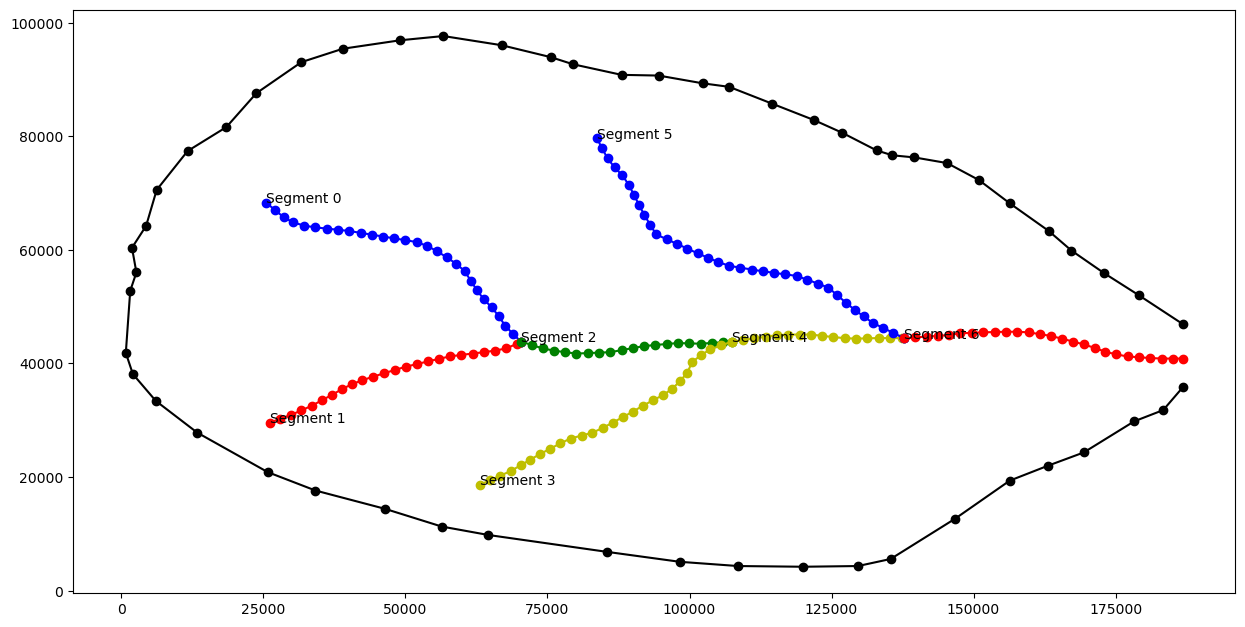

In [4]:
# densify the segments; this is not really needed for drn/sfr but could be important for swf
# sgsd is the densified line segments ordered from upstream to downstream
sgsd = [
    densify_geometry(sg, 2000., keep_internal_nodes=False) for sg in sgs
]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.plot(bp[:, 0], bp[:, 1], "ko-")
line_symbols = ("bo-", "ro-", "go-", "yo-", "yo-", "bo-", "ro-")
for iseg, (sg, fmt) in enumerate(zip(sgsd, line_symbols)):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], fmt)
    xstart, ystart = sg[0]
    ax.text(xstart, ystart, f"Segment {iseg}")

In [5]:
def set_idomain(grid, boundary):
    from flopy.utils.gridintersect import GridIntersect
    from shapely.geometry import Polygon

    ix = GridIntersect(grid, method="vertex", rtree=True)
    result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]
    idx = np.array(idx, dtype=int)
    nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    print(idx.shape, idx.ndim)
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])
    # idx = (idx[:, 0], idx[:, 1])
    idomain = np.zeros(grid.shape[1:], dtype=int)
    idomain[idx] = 1
    idomain = idomain.reshape(grid.shape)
    grid.idomain = idomain

In [6]:
# Create a regular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 1666.66666667
nlay = 1
nrow = int(Ly / dy) + 1
ncol = int(Lx / dx) + 1
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
top = np.ones((nrow, ncol)) * 1000.0
botm = np.ones((nlay, nrow, ncol)) * -100.0
regular_grid = flopy.discretization.StructuredGrid(
    nlay=nlay, delr=delr, delc=delc, xoff=0.0, yoff=0.0, top=top, botm=botm
)

set_idomain(regular_grid, boundary_polygon)

180000 100000 60 108
(4580, 2) 2


In [7]:
pth = data_path / "fine_topo.asc"
assert pth.is_dir
fine_topo = flopy.utils.Raster.load(pth)
top_rg = fine_topo.resample_to_grid(
    regular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

/Users/langevin/miniconda3/envs/modflow6/lib/python3.10/site-packages/rasterstats/io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


In [8]:
ixs = flopy.utils.GridIntersect(regular_grid, method="structured")
cellids = []
for sg in sgsd:
    v = ixs.intersect(shapely.LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_rg = np.zeros(regular_grid.shape[1:])
for loc in cellids:
    intersection_rg[loc] = 1

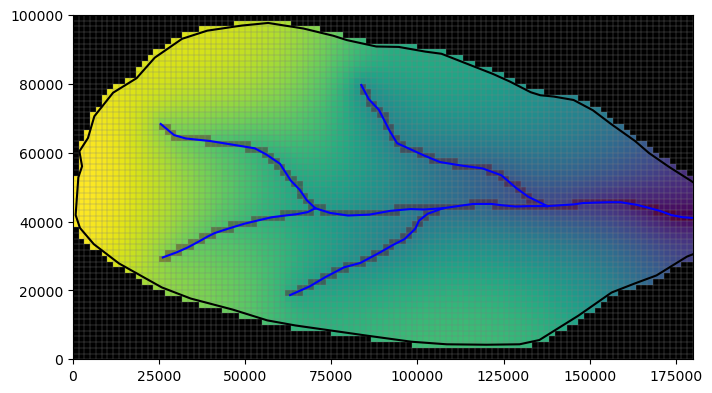

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=regular_grid)
ax.set_aspect("equal")
pmv.plot_array(top_rg)
pmv.plot_array(
    intersection_rg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
pmv.plot_grid(lw=0.25, color="0.5")
pmv.plot_inactive()
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

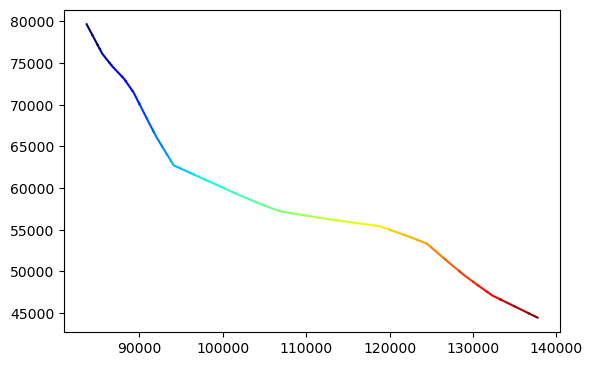

In [10]:
ix = ixs.intersect(shapely.LineString(sgsd[5]), sort_by_cellid=True)

n = ix.shape[0]
ax = plt.axes()
ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, n)])
ax.set_aspect(1.0)
for xy in ix["vertices"]:
    a = np.array(xy)
    plt.plot(a[:, 0], a[:, 1])

In [11]:
su = streamutil.StreamUtil(sgsd, upstream_segments, regular_grid)
sfr_reach_data = su.get_sfr_reachdata()

ia_seg2reach = su.ia_seg2reach
nsegments = su.nsegments
nreaches = su.nreaches
intersection_results = su.intersection_results
reach_connectivity = su.reach_connectivity

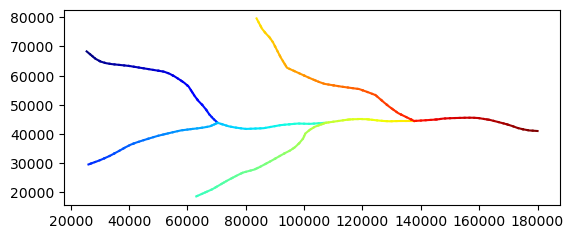

In [12]:
# color reaches by global reach number
ax = plt.axes()
ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, nreaches)])
ax.set_aspect(1.0)

for iseg in range(nsegments):

    # get segment and intersection results
    v = intersection_results[iseg]

    for xy in v["vertices"]:
        a = np.array(xy)
        plt.plot(a[:, 0], a[:, 1])

## Create the MODFLOW 6 Model

### Steady-State Drain Simulation

In [13]:
# Create stress period data for a drain representation of the streams
stream_width = 100.
stream_bottom = -3.
ddrn = 1.0
ndrain = len(reach_connectivity)
drn_spd = []
for idrn in range(ndrain):
    irow, icol = sfr_reach_data["cellid"][idrn]
    cond = 1. * sfr_reach_data["length"][idrn] * stream_width / 1.
    elev = top_rg[irow, icol] + stream_bottom
    drn_spd.append((0, irow, icol, elev, cond, ddrn))

In [14]:
ws = './mf6_ss_drn'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    # no_ptcrecord="all",
    outer_maximum=100, 
    inner_maximum=50, 
    linear_acceleration="bicgstab",
    relaxation_factor=1.0,
    # under_relaxation="DBD",
    # under_relaxation_theta=0.9,
    # under_relaxation_kappa=0.0001,
    # under_relaxation_gamma=0.0,
    # backtracking_number=5,
    # backtracking_tolerance=1.0,
    # backtracking_reduction_factor=0.3,
    # backtracking_residual_limit=100.0,
)
gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname=name, 
    save_flows=True, 
    newtonoptions="NEWTON UNDER_RELAXATION"
)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=dx,
    delc=dy, 
    top=top_rg,
    botm=top_rg - 60., 
    idomain=regular_grid.idomain
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top_rg)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    icelltype=1,
    k=50.)
drn = flopy.mf6.ModflowGwfdrn(
    gwf, 
    print_flows=True,
    auxiliary=["ddrn"],
    #auxdepthname="ddrn",
    stress_period_data=drn_spd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=1.e-4)
# evt = flopy.mf6.ModflowGwfevta(gwf, surface=top_rg, depth=2., rate=1.e-4)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 252 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 


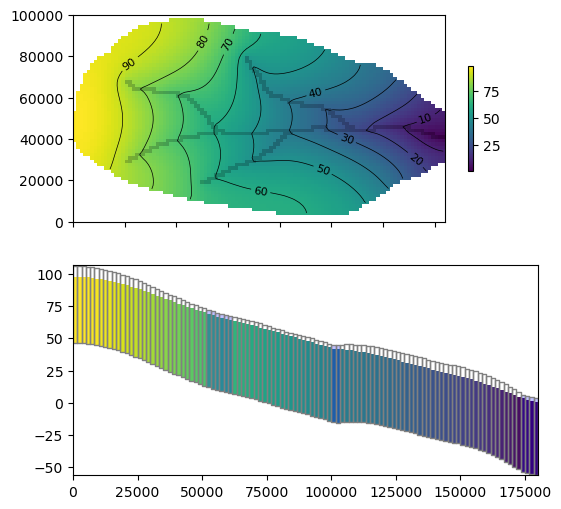

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.set_aspect(1)
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pa = pmv.plot_array(head)
#pmv.plot_grid(colors='white')
cs = pmv.contour_array(head, levels=np.linspace(0, 100., 11), colors="k", linewidths=0.5)
ax.clabel(cs, inline=1, fontsize=8)
pmv.plot_bc("DRN", color="k", alpha=0.1)
plt.colorbar(pa, shrink=0.5)
#pmv.plot_vector(qx, qy, normalize=True, color="white")

ax = axes[1]
#ax.set_aspect(100)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row": 35}, ax=ax)
pxs.plot_array(head, head=head)
pxs.plot_bc("DRN", color="blue", alpha=0.25)
pxs.plot_grid()

Text(0.5, 1.0, 'Depth to Water: min=1.24 max=17.09')

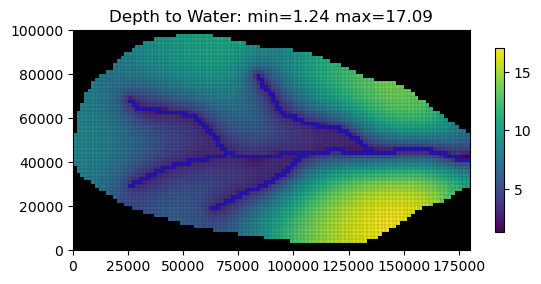

In [16]:
pmv = flopy.plot.PlotMapView(gwf)
depth_water = top_rg - head[0]
pa = pmv.plot_array(depth_water)
pmv.plot_grid(colors='k', linewidth=0.1)
pmv.plot_bc("DRN", color="blue", alpha=0.25)
pmv.plot_inactive()
plt.colorbar(pa, shrink=0.5)
wtmin = depth_water[depth_water != -1.e30].min()
wtmax = depth_water[depth_water != -1.e30].max()
plt.title(f"Depth to Water: min={wtmin:.2f} max={wtmax:.2f}")

### Steady-State Stream-Flow Routing (SFR) Simulation

In [17]:
# setup sfr packagedata
rwid = stream_width
slope = 0.0001
rbth = 1.0
rhk = 1.0
roughness = 0.035
ustrf = 1.0
ndv = 0

sfrpd = su.get_sfr_packagedata()
sfrpd["rwid"] = stream_width
sfrpd["rgrd"] = slope
sfrpd["rtp"] = top_rg[(sfrpd["row"], sfrpd["column"])] + stream_bottom
sfrpd["rbth"] = rbth
sfrpd["rhk"] = rhk
sfrpd["man"] = roughness
sfrpd["ustrf"] = ustrf
sfrpd["ndv"] = ndv
print(sfrpd[0])
print(sfrpd.dtype)

# sfr_packagedata = []
# for irch in range(nreaches):
#     nconn = len(reach_connectivity[irch]) - 1
#     cellid_rowcol = sfr_reach_data["cellid"][irch]
#     rp = [
#         irch,
#         #(0,) + cellid_rowcol,
#         0, cellid_rowcol[0], cellid_rowcol[1],
#         sfr_reach_data["length"][irch],
#         rwid,
#         slope,
#         top_rg[cellid_rowcol] + stream_bottom,
#         rbth,
#         rhk,
#         roughness,
#         nconn,
#         ustrf,
#         ndv,
#     ]
#     sfr_packagedata.append(rp)
#     sfrpd[irch] = tuple(rp)
# print(sfr_packagedata[0])

(0, 0, 19, 15, 1562.10343685, 100., 0.0001, 83.48148092, 1., 1., 0.035, 1, 1., 0)
(numpy.record, [('ifno', '<i8'), ('layer', '<i8'), ('row', '<i8'), ('column', '<i8'), ('rlen', '<f8'), ('rwid', '<f8'), ('rgrd', '<f8'), ('rtp', '<f8'), ('rbth', '<f8'), ('rhk', '<f8'), ('man', '<f8'), ('ncon', '<i8'), ('ustrf', '<f8'), ('ndv', '<i8')])


In [18]:
ws = './mf6_ss_sfr'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    # no_ptcrecord="all",
    outer_maximum=50, 
    inner_maximum=10,
    inner_dvclose=1.e-8,
    outer_dvclose=1.e-8,
    linear_acceleration="bicgstab",
    relaxation_factor=0.97,
    # under_relaxation="DBD",
    # under_relaxation_theta=0.9,
    # under_relaxation_kappa=0.0001,
    # under_relaxation_gamma=0.0,
    backtracking_number=5,
    backtracking_tolerance=1.0,
    backtracking_reduction_factor=0.3,
    backtracking_residual_limit=100.0,
)
gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname=name, 
    save_flows=True, 
    newtonoptions="NEWTON UNDER_RELAXATION"
)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=dx,
    delc=dy, 
    top=top_rg,
    botm=top_rg - 60., 
    idomain=regular_grid.idomain
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top_rg)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    icelltype=1,
    k=50.)

sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    save_flows=True,
    print_stage=True,
    print_flows=True,
    print_input=True,
    length_conversion=1.0,
    time_conversion=86400.0,
    budget_filerecord=f"{name}.sfr.cbc",
    mover=False,
    nreaches=nreaches,
    #packagedata=sfr_packagedata,
    packagedata=sfrpd,
    connectiondata=reach_connectivity,
    # crosssections=crosssections,
    perioddata=[],
)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=1.e-4)
# evt = flopy.mf6.ModflowGwfevta(gwf, surface=top_rg, depth=2., rate=1.e-4)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            )
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()
sfrbud = sfr.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sfr_0...
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

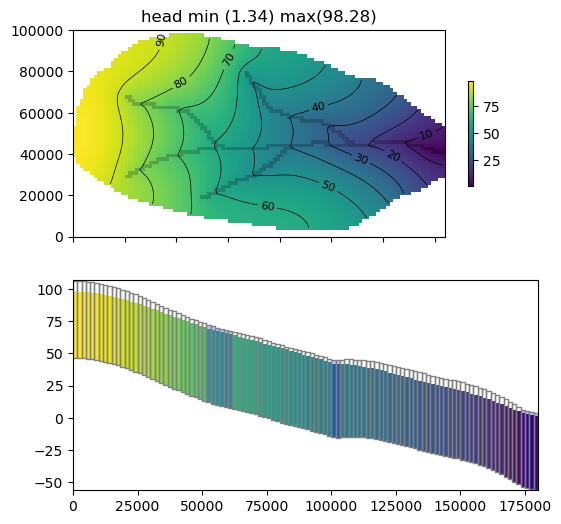

In [19]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.set_aspect(1)
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pa = pmv.plot_array(head)
#pmv.plot_grid(colors='white')
cs = pmv.contour_array(head, levels=np.linspace(0, 100., 11), colors="k", linewidths=0.5)
ax.clabel(cs, inline=1, fontsize=8)
pmv.plot_bc("SFR", color="k", alpha=0.1)
plt.colorbar(pa, shrink=0.5)
#pmv.plot_vector(qx, qy, normalize=True, color="white")
idx = head < 1.e30
hmin = head[idx].min()
hmax = head[idx].max()
ax.set_title(f"head min ({hmin:.2f}) max({hmax:.2f})")

ax = axes[1]
#ax.set_aspect(100)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row": 35}, ax=ax)
pxs.plot_array(head, head=head)
pxs.plot_bc("SFR", color="blue", alpha=0.25)
pxs.plot_grid()


Text(0.5, 1.0, 'Depth to Water: min=0.59 max=16.82')

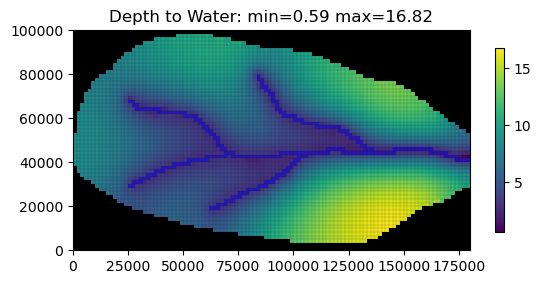

In [20]:
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
depth_water = top_rg - head[0]
pa = pmv.plot_array(depth_water)
pmv.plot_grid(colors='k', linewidth=0.1)
pmv.plot_bc("SFR", color="blue", alpha=0.25)
pmv.plot_inactive()
plt.colorbar(pa, shrink=0.5)
wtmin = depth_water[depth_water != -1.e30].min()
wtmax = depth_water[depth_water != -1.e30].max()
plt.title(f"Depth to Water: min={wtmin:.2f} max={wtmax:.2f}")

(0.0, 100000.0)

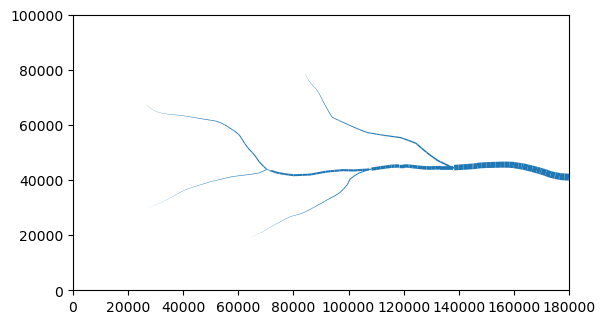

In [21]:
def get_line_collection(lines):
    """
    Convert list of shapely linestrings to matplotlib LineCollection
    """
    from matplotlib.collections import LineCollection
    line_list = []
    for line in lines:
        x, y = line.xy
        x = np.array(x)
        y = np.array(y)
        line_list.append([(xp, yp) for xp, yp in zip(x, y) ])
    return LineCollection(line_list)

lines = sfr_reach_data["linestring"]
lc = get_line_collection(lines)

leakage = bud.get_data(text="SFR")[0]["q"]

fjf = sfrbud.get_data(text="FLOW-JA-FACE")[0]
idx = np.where(fjf["q"] < 0)
qoutflow = np.zeros(nreaches)
qoutflow[fjf["node2"][idx]-1]=-fjf["q"][idx]

lc.set_linewidth(qoutflow/qoutflow.max()*5)

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.add_collection(lc)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)


### Steady-State SWF/GWF Coupled Simulation

In [22]:
ws = './mf6_ss_swf'
name = 'mysim'
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=exe_name)

time_units = "days"
time_conversion = 86400.

steady = True
nper = 1
perlen = 1000.
nstp = 1
tsmult = 1.0
perioddata = []
for i in range(nper):
    perioddata.append((perlen, nstp, tsmult))
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=perioddata, time_units=time_units)

# backtracking seems to really help for this problem
ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    # no_ptcrecord="all",
    outer_maximum=50, 
    inner_maximum=10,
    inner_dvclose=1.e-8,
    outer_dvclose=1.e-8,
    linear_acceleration="bicgstab",
    relaxation_factor=0.97,
    # under_relaxation="DBD",
    # under_relaxation_theta=0.9,
    # under_relaxation_kappa=0.0001,
    # under_relaxation_gamma=0.0,
    backtracking_number=5,
    backtracking_tolerance=1.0,
    backtracking_reduction_factor=0.3,
    backtracking_residual_limit=100.0,
)

name = "swfmodel"
swf = flopy.mf6.ModflowSwf(sim, modelname=name, save_flows=True)

vertices, cell2d = su.get_vertices_cell2d(grid_based=True)
disl = flopy.mf6.ModflowSwfdisl(
    swf, 
    nodes=su.nreaches, 
    nvert=len(vertices),
    reach_length=su.sfr_reach_length,
    reach_bottom=sfrpd["rtp"],
    #toreach=toreach,   # -1 gives 0 in one-based, which means outflow cell
    idomain=1,
    vertices=vertices, 
    cell2d=cell2d,
)

rough = 0.035
dfw = flopy.mf6.ModflowSwfdfw(
    swf, 
    print_flows=True,
    save_flows=True,
    length_conversion=1.0,
    time_conversion=time_conversion,
    width=stream_width, 
    manningsn=rough,
    slope=0.0001,
    idcxs=0,
)

if not steady:
    sto = flopy.mf6.ModflowSwfsto(
        swf,
        save_flows=True,
    )

strt = top_rg[(sfrpd["row"], sfrpd["column"])]
ic = flopy.mf6.ModflowSwfic(swf, strt=strt)

xfraction = [0., 0., 1., 1.]
height = [100., 0., 0., 100.]
mannfraction = [1., 1., 1., 1.]
cxsdata = list(zip(xfraction, height, mannfraction))
cxs = flopy.mf6.ModflowSwfcxs(
    swf,
    nsections=1,
    npoints=4,
    packagedata=[(0, 4)],
    crosssectiondata=cxsdata,
)

# # note: for specifying zero-based reach number, put reach number in tuple
# fname = f"{name}.zdg.obs.csv"
# zdg_obs = {
#     fname: [
#         ("OUTFLOW", "ZDG", (su.nreaches - 1,)),
#     ],
#     "digits": 10,
# }
# idcxs = 0 # use cross section 0
# width = stream_width
# slope = 0.001
# rough = rough
# spd = [((su.nreaches - 1,), idcxs, width, slope, rough)]
# zdg = flopy.mf6.ModflowSwfzdg(
#     swf,
#     observations=zdg_obs,
#     print_input=True,
#     maxbound=len(spd),
#     stress_period_data=spd,
# )

chd = flopy.mf6.ModflowSwfchd(
    swf,
    maxbound=1,
    print_input=True,
    print_flows=True,
    stress_period_data=[(su.nreaches - 1, 1.0)]
)


# output control
oc = flopy.mf6.ModflowSwfoc(
    swf,
    budget_filerecord=f"{name}.bud",
    stage_filerecord=f"{name}.stage",
    saverecord=[("STAGE", "ALL"), ("BUDGET", "ALL"), ],
    printrecord=[("STAGE", "LAST"),("BUDGET", "ALL"), ],
)

name = "gwfmodel"
gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname=name, 
    save_flows=True, 
    newtonoptions="NEWTON UNDER_RELAXATION"
)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=dx,
    delc=dy, 
    top=top_rg,
    botm=top_rg - 60., 
    idomain=regular_grid.idomain
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top_rg)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    icelltype=1,
    k=50.)

if not steady:
    sto = flopy.mf6.ModflowGwfsto(gwf, sy=0.1, ss=1.e-5)

rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=1.e-4)
# evt = flopy.mf6.ModflowGwfevta(gwf, surface=top_rg, depth=2., rate=1.e-4)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)

swfgwf_data = []

for i in range(su.nreaches):
    ifno = sfrpd["ifno"][i]
    layer = sfrpd["layer"][i]
    row = sfrpd["row"][i]
    column = sfrpd["column"][i]
    streambed_hydraulic_conductivity = 1.0
    cond = sfr_reach_data["length"][i] * stream_width / 1.
    cond = cond * streambed_hydraulic_conductivity
    swfgwf_data.append([(ifno,), (layer, row, column), cond])

swfgwf = flopy.mf6.ModflowSwfgwf(
    sim,
    print_input=True,
    print_flows=True,
    exgtype="SWF6-GWF6",
    nexg=len(swfgwf_data),
    exgmnamea="swfmodel",
    exgmnameb="gwfmodel",
    exchangedata=swfgwf_data,
)

sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()
sfrbud = sfr.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package mysim.swfgwf...
  writing model swfmodel...
    writing model name file...
    writing package disl...
    writing package dfw...
    writing package ic...
    writing package cxs...
    writing package chd_0...
    writing package oc...
  writing model gwfmodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan  2 2024 12:43:12 with GCC version 13.2.0

This software is preliminary

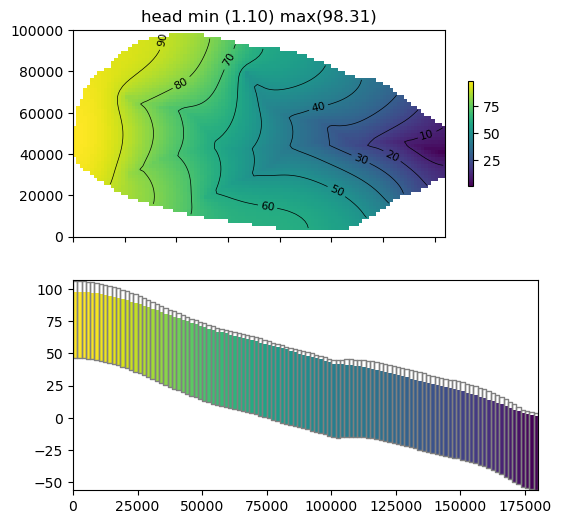

In [23]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.set_aspect(1)
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pa = pmv.plot_array(head)
#pmv.plot_grid(colors='white')
cs = pmv.contour_array(head, levels=np.linspace(0, 100., 11), colors="k", linewidths=0.5)
ax.clabel(cs, inline=1, fontsize=8)
#pmv.plot_bc("SFR", color="k", alpha=0.1)
plt.colorbar(pa, shrink=0.5)
#pmv.plot_vector(qx, qy, normalize=True, color="white")
idx = head < 1.e30
hmin = head[idx].min()
hmax = head[idx].max()
ax.set_title(f"head min ({hmin:.2f}) max({hmax:.2f})")

ax = axes[1]
#ax.set_aspect(100)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row": 35}, ax=ax)
pxs.plot_array(head, head=head)
#pxs.plot_bc("SFR", color="blue", alpha=0.25)
pxs.plot_grid()


Text(0.5, 1.0, 'Depth to Water: min=0.62 max=16.90')

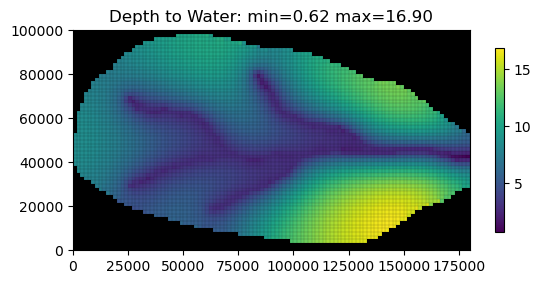

In [24]:
pmv = flopy.plot.PlotMapView(gwf)
depth_water = top_rg - head[0]
pa = pmv.plot_array(depth_water)
pmv.plot_grid(colors='k', linewidth=0.1)
#pmv.plot_bc("SFR", color="blue", alpha=0.25)
pmv.plot_inactive()
plt.colorbar(pa, shrink=0.5)
wtmin = depth_water[depth_water != -1.e30].min()
wtmax = depth_water[depth_water != -1.e30].max()
plt.title(f"Depth to Water: min={wtmin:.2f} max={wtmax:.2f}")

In [25]:
# calculate stream depth
stage = swf.output.stage().get_data().flatten()
depth = stage - sfrpd["rtp"]

fpth = pl.Path(ws) / "swfmodel.disl.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja

fpth = pl.Path(ws) / "swfmodel.bud"
budobj = flopy.utils.binaryfile.CellBudgetFile(fpth)
flowja = budobj.get_data(text="FLOW-JA-FACE")[0].flatten()

# process the flowja array; used to calculate leakage, but
# that can be done better when leakage terms are added to the
# model budget files
nreach = ia.shape[0] - 1
leakage = np.zeros(nreach)
qoutflow = np.zeros(nreach)
for n in range(nreach):
    for ipos in range(ia[n] + 1, ia[n + 1]):
        m = ja[ipos]
        q = flowja[ipos]
        leakage[n] -= q
        if q < 0:
            qoutflow[n] -= q

idx = leakage < 0
leakage[idx] = 0 # filter out large negative value
print(leakage.min(), leakage.max())
print(qoutflow.min(), qoutflow.max())

0.0 28741.030316941786
0.0 1255724.1090635846


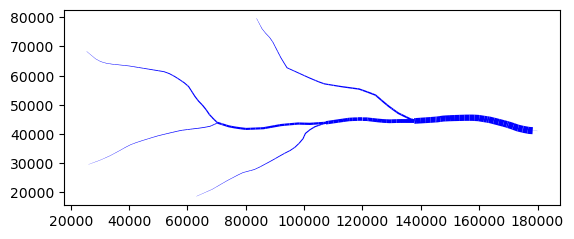

In [26]:
def get_seg(n, vertices, cell2d):
    seg = []
    for iv in cell2d[n][3:]:
        row = vertices[iv]
        seg.append((row[1], row[2]))
    return seg

def get_segs(vertices, cell2d):
    segments = []
    for n in range(len(cell2d)):
        segments.append(get_seg(n, vertices, cell2d))
    return segments

arr = depth
arr = leakage
arr = qoutflow
#arr = np.random.random(nreach) * 100
amin, amax = arr.min(), arr.max()
normalized_arr = (arr - amin)/(amax - amin) 

import matplotlib.colors
import matplotlib.collections
segments = get_segs(vertices, cell2d)
lc = matplotlib.collections.LineCollection(
    segments=segments,
)
#lc.set_array(arr)
lc.set_colors("blue")
lc.set_cmap(plt.cm.Blues)
#lc.set_norm(matplotlib.colors.Normalize(vmin=0, vmax=19))
lc.set_linewidths(.1 + 5 * normalized_arr)

ax = plt.subplot(1, 1, 1, aspect="equal")
c = ax.add_collection(lc)
#plt.colorbar(c, shrink=0.25)
ax.autoscale()

In [27]:
# for n in range(ia.shape[0] - 1):
#     nrc = len(reach_connectivity[n])
#     nrja = ja[ia[n]:ia[n+1]].shape[0]
#     # print(n, reach_connectivity[n], ja[ia[n]:ia[n+1]])
#     if nrc != nrja:
#         print("not equal", n, nrc, nrja)

### Steady-State SWF-Only Simulation

In [28]:
ws = './mf6_swf'
name = 'mysim'
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=exe_name)

time_units = "days"
time_conversion = 86400.
# time_units = "seconds"
# time_conversion = 1.


steady = True
nper = 1
perlen = 1000.
nstp = 1
tsmult = 1.0
perioddata = []
for i in range(nper):
    perioddata.append((perlen, nstp, tsmult))
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=perioddata, time_units=time_units)

ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    # no_ptcrecord="all",
    outer_maximum=1000, 
    inner_maximum=5,
    inner_dvclose=1.e-8,
    outer_dvclose=1.e-8,
    linear_acceleration="bicgstab",
    relaxation_factor=0.97,
    # under_relaxation="DBD",
    # under_relaxation_theta=0.9,
    # under_relaxation_kappa=0.0001,
    # under_relaxation_gamma=0.0,
    backtracking_number=5,
    backtracking_tolerance=1.0,
    backtracking_reduction_factor=0.3,
    backtracking_residual_limit=100.0,
)

name = "swfmodel"
swf = flopy.mf6.ModflowSwf(sim, modelname=name, save_flows=True)

vertices, cell2d = su.get_vertices_cell2d(grid_based=True)
disl = flopy.mf6.ModflowSwfdisl(
    swf, 
    nodes=su.nreaches, 
    nvert=len(vertices),
    reach_length=su.sfr_reach_length,
    reach_bottom=sfrpd["rtp"],
    #toreach=toreach,   # -1 gives 0 in one-based, which means outflow cell
    idomain=1,
    vertices=vertices, 
    cell2d=cell2d,
)

rough = 0.035
dfw = flopy.mf6.ModflowSwfdfw(
    swf, 
    print_flows=True,
    save_flows=True,
    length_conversion=1.0,
    time_conversion=time_conversion,
    width=stream_width, 
    manningsn=rough,
    slope=0.0001,
    idcxs=0,
)

if not steady:
    sto = flopy.mf6.ModflowSwfsto(
        swf,
        save_flows=True,
    )

strt = top_rg[(sfrpd["row"], sfrpd["column"])] + 0.
ic = flopy.mf6.ModflowSwfic(swf, strt=strt)

xfraction = [0., 0., 1., 1.]
height = [100., 0., 0., 100.]
mannfraction = [1., 1., 1., 1.]
cxsdata = list(zip(xfraction, height, mannfraction))
cxs = flopy.mf6.ModflowSwfcxs(
    swf,
    nsections=1,
    npoints=4,
    packagedata=[(0, 4)],
    crosssectiondata=cxsdata,
)

chd = flopy.mf6.ModflowSwfchd(
    swf,
    maxbound=1,
    print_input=True,
    print_flows=True,
    stress_period_data=[(su.nreaches - 1, 1.0)]
)

# add flow to first reach in segments 0, 1, 3, and 5
inflow_rate = 100.000 * time_conversion
flwlist = [
    [(0,), inflow_rate],
    [(42,), inflow_rate],
    [(104,), inflow_rate],
    [(168,), inflow_rate],
]
flw = flopy.mf6.ModflowSwfflw(
    swf,
    maxbound=len(flwlist),
    print_input=True,
    print_flows=True,
    stress_period_data=flwlist,
)

# output control
oc = flopy.mf6.ModflowSwfoc(
    swf,
    budget_filerecord=f"{name}.bud",
    stage_filerecord=f"{name}.stage",
    saverecord=[("STAGE", "ALL"), ("BUDGET", "ALL"), ],
    printrecord=[("STAGE", "LAST"),("BUDGET", "ALL"), ],
)

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model swfmodel...
    writing model name file...
    writing package disl...
    writing package dfw...
    writing package ic...
    writing package cxs...
    writing package chd_0...
    writing package flw_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan  2 2024 12:43:12 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warr

(True, [])

In [29]:
stage = swf.output.stage().get_data().flatten()
depth = stage - sfrpd["rtp"]

fpth = pl.Path(ws) / "swfmodel.disl.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja

fpth = pl.Path(ws) / "swfmodel.bud"
budobj = flopy.utils.binaryfile.CellBudgetFile(fpth)
flowja = budobj.get_data(text="FLOW-JA-FACE")[0].flatten()

# process the flowja array
nreach = ia.shape[0] - 1
qoutflow = np.zeros(nreach)
for n in range(nreach):
    for ipos in range(ia[n] + 1, ia[n + 1]):
        m = ja[ipos]
        q = flowja[ipos]
        if q < 0:
            qoutflow[n] -= q

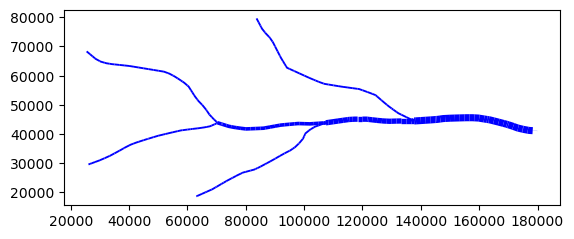

In [30]:
arr = depth
arr = qoutflow
amin, amax = arr.min(), arr.max()
normalized_arr = (arr - amin)/(amax - amin) 

import matplotlib.colors
import matplotlib.collections
segments = get_segs(vertices, cell2d)
lc = matplotlib.collections.LineCollection(
    segments=segments,
)
#lc.set_array(arr)
lc.set_colors("blue")
lc.set_cmap(plt.cm.Blues)
#lc.set_norm(matplotlib.colors.Normalize(vmin=0, vmax=19))
lc.set_linewidths(.1 + 5 * normalized_arr)

ax = plt.subplot(1, 1, 1, aspect="equal")
c = ax.add_collection(lc)
ax.autoscale()